Variables (input and output) drawn from [Cloete and Mbati](http://www.cepd.org.za/files/HESummit_Commission4_Differentiation.pdf).

Input variables:
* %’s headcount enrolment in SET
* M&D headcount enrolments
* student: academic staff FTE ratios
* permanent staff with doctoral degrees
* private income 
* government student fee income per student

Output variables:
* success rate
* graduation rate
* weighted research output by permanent staff member

Data from [CHET's SA Higher Education Performance Data](http://www.chet.org.za/data/sahe-open-data)

In [1]:
import pandas
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import cdist

In [2]:
%matplotlib inline

In [3]:
pwd

'/home/pvh/Documents/code/HEMIS/notebooks'

In [4]:
data_directory = '../data'

In [5]:
enrollment_spreadsheet = data_directory + '/Table 4 Enrolments by CESM and Major Field of Study 2015.xlsx'

In [6]:
data = pandas.read_excel(enrollment_spreadsheet, skiprows=35,
                         index_col=0)

### Overall enrollment in Higher Education in SA, 2015

In [7]:
data.drop(data.index[0])

,Undergraduate,PG < Masters,Masters,Doctorate,TOTAL
Major Field of Study,,,,,
Natural sciences,117401.668,7626.000,9846.166,5683.666,140557.500
Engineering and technology,83967.916,2498.416,6737.250,1695.500,94899.082
Health sciences,43577.583,4569.500,9178.667,2152.000,59477.750
"Business, economic and management sciences",236557.334,23538.334,11592.417,2140.000,273828.085
Education,134434.751,30529.834,3427.083,2158.000,170549.668
Humanities and social sciences,209710.750,15740.915,14764.418,5683.833,245899.916
Unknown,0.000,0.000,0.000,0.000,0.000
Total,825650.002,84502.999,55546.001,19512.999,985212.001


In [8]:
# total enrollment in SET subjects
sum(data.loc[['Natural sciences', 'Engineering and technology', 'Health sciences'],'TOTAL'])

294934.332

In [9]:
def get_SET_md_enrollment(filename, sheet_name):
    data = pandas.read_excel(filename, sheet_name=sheet_name, header=None)
    institution_name = data.iloc[0,0]
    rows_to_skip = data[data[0] == 'Major Field of Study'].index[0]
    data = pandas.read_excel(filename, sheet_name=sheet_name, skiprows=rows_to_skip, index_col=0)
    data.drop(data.index[0])
    SET_enrollment = sum(data.loc[['Natural sciences', 'Engineering and technology', 'Health sciences'],'TOTAL'])
    total_enrollment = data.loc['Total', 'TOTAL']
    m_and_d_enrollment = int(data.loc[['Total'], ['Masters ', 'Doctorate']].sum(axis=1))
    return institution_name, { 'SET percentage': SET_enrollment / total_enrollment, 
                                'M and D enrollment': m_and_d_enrollment }
    

In [10]:
book = pandas.ExcelFile(enrollment_spreadsheet)
enroll_dict = dict()
for sheet_name in book.sheet_names[1:]:
    enroll = get_SET_md_enrollment(enrollment_spreadsheet, sheet_name)
    uni_name_code = enroll[0]
    uni_code = uni_name_code.split()[0]
    uni_name = uni_name_code.split(' - ', maxsplit=1)[1].strip()
    enroll_stats = enroll[1]
    enroll_stats['University Name'] = uni_name
    enroll_dict[uni_code] = enroll_stats

In [11]:
overall_data = pandas.DataFrame.from_dict(enroll_dict, orient='index')

In [12]:
headcount_spreadsheet = data_directory + '/Table 1 Student Headcounts and FTEs.xlsx'

In [13]:
student_to_staff_ratio_spreadsheet = data_directory + '/Table 17 Ratio of Student FTEs to Staff FTEs.xlsx'

In [14]:
data = pandas.read_excel(student_to_staff_ratio_spreadsheet, skiprows=7, index_col=0)
data = data.iloc[1:-1]
data.index = data.index.str.strip()

In [15]:
student_to_staff_2015 = data[2015]
student_to_staff_2015.name = 'Student To Staff Ratio'
student_to_staff_2015.index

Index(['H01', 'H02', 'H03', 'H04', 'H05', 'H06', 'H07', 'H08', 'H09', 'H10',
       'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'H17', 'H18', 'H19', 'H20',
       'H21', 'H22', 'H25', 'H26'],
      dtype='object', name='Institution Number ')

In [16]:
overall_data = pandas.concat([overall_data, student_to_staff_2015],axis=1)

In [17]:
staff_types_spreadsheet = data_directory + '/Table 11 Number of staff all types.xlsx'

In [18]:
data = pandas.read_excel(staff_types_spreadsheet, skiprows=8, index_col=0)
data = data[1:-1]
data.index = data.index.str.strip()

In [19]:
academic_staff = data.loc[:,['Academic.6']]
support_staff = data.loc[:,['Total.6']].values - data.loc[:,['Academic.6']].values

In [20]:
total_staff = data.loc[:,['Total.6']]

In [21]:
academic_staff_ratio = pandas.Series(data=(academic_staff.values / total_staff.values).squeeze(), index=data.index, name='Academic Staff %')

In [22]:
academic_staff_ratio_data = pandas.concat([data, academic_staff_ratio], axis=1).loc[:,['University ', 'University Name ', 'Academic Staff %', 'Total.6']]

In [23]:
academic_staff_ratio_data.index = academic_staff_ratio_data.loc[:,'University ']

In [24]:
academic_staff_ratio_data = academic_staff_ratio_data.drop('University ', axis=1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8951a51f60>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f8951a38e10>], dtype=object)

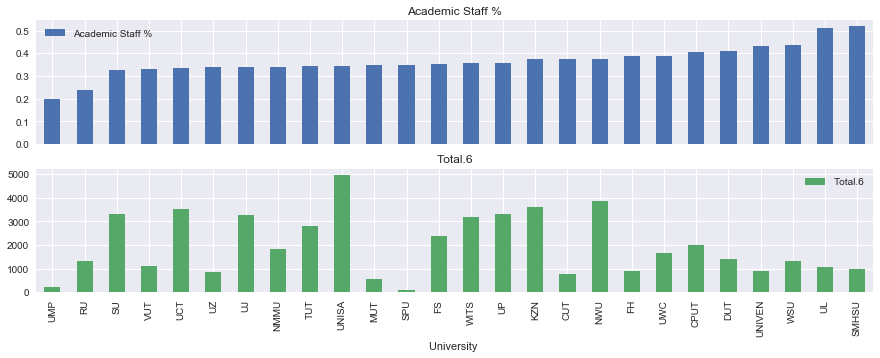

In [25]:
academic_staff_ratio_data.sort_values('Academic Staff %').loc[:,['Academic Staff %', 'Total.6']].plot(kind='bar',
                                                                                                      subplots=True,
                                                                                          figsize=(15,5))


In [26]:
staff_qualifications_spreadsheed = data_directory + '/Table 13 Staff Qualifications.xlsx'

In [27]:
column_names = ['University', 'University Name', 'Doctors', 'Masters', 'Other',
       'Total', 'Doctors.1', 'Masters.1', 'Other.1', 'Total.1', 'Doctors.2',
       'Masters.2', 'Other.2', 'Total.2', 'Doctors.3', 'Masters.3', 'Other.3',
       'Total.3', 'Doctors.4', 'Masters.4', 'Other.4', 'Total.4', 'Doctors.5',
       'Masters.5', 'Other.5', 'Total.5', 'Doctors.6', 'Masters.6', 'Other.6',
       'Total.6']

In [28]:
data = pandas.read_excel(staff_qualifications_spreadsheed, skiprows=8, index_col=0, names=column_names)
data = data[:-1]
data.index = data.index.str.strip()
data.index

Index(['H01', 'H02', 'H03', 'H04', 'H05', 'H06', 'H07', 'H08', 'H09', 'H10',
       'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'H17', 'H18', 'H19', 'H20',
       'H21', 'H22', 'H23', 'H24', 'H25', 'H26'],
      dtype='object')

In [29]:
staff_with_phd_2015 = data.loc[:,['Doctors.6', 'Total.6']]
staff_with_phd_2015.columns = ['Staff with PhD', 'Total Academic Staff']

In [30]:
overall_data = pandas.concat([overall_data, staff_with_phd_2015], axis=1)

In [31]:
income_source_spreadsheet = data_directory + '/Table 22 Sources of Income.xlsx'

In [32]:
data = pandas.read_excel(income_source_spreadsheet, skiprows=8, index_col=0)
data.index = data.index.str.strip()
data = data[:-1]

In [33]:
data.columns

Index(['University ', 'University Name ', 'Government funds', 'Student fees',
       'Private income', 'Government funds.1', 'Student fees.1',
       'Private income.1', 'Government funds.2', 'Student fees.2',
       'Private income.2', 'Government funds.3', 'Student fees.3',
       'Private income.3', 'Government funds.4', 'Student fees.4',
       'Private income.4', 'Government funds.5', 'Student fees.5',
       'Private income.5', 'Government funds.6', 'Student fees.6',
       'Private income.6'],
      dtype='object')

In [34]:
private_income_percentage = data['Private income.6']
private_income_percentage.name = 'Private income %'

In [35]:
overall_data = pandas.concat([overall_data, private_income_percentage], axis=1)

In [36]:
fee_income_per_fte_spreadsheed = data_directory + '/Table 26 Formal Tution Fee Income per FTE.xlsx'

In [37]:
data = pandas.read_excel(fee_income_per_fte_spreadsheed, skiprows=7, index_col=0)
data.index = data.index.str.strip()
data = data[1:-1]

In [38]:
tuition_and_fee_income_per_fte_2015 = data[2015]
tuition_and_fee_income_per_fte_2015.name = 'Tution and Fee Income Per FTE Student'

In [39]:
overall_data = pandas.concat([overall_data, tuition_and_fee_income_per_fte_2015], axis=1)

Having collected all the data for the input variables (plus total academic staff) I drop the data for SPU, UMP and SMHSU. These universities were founded in 2014, 2014 and 2015 respectively, and data for them is incomplete. We also drop the 'Total Academic Staff' column because this correlates with 'Staff with PhD'.

In [40]:
institutions_to_drop = ['H23', 'H24', 'H26']
overall_data = overall_data.drop(institutions_to_drop)
overall_data = overall_data.drop('Total Academic Staff', axis=1)
overall_data

,SET percentage,University Name,M and D enrollment,Student To Staff Ratio,Staff with PhD,Private income %,Tution and Fee Income Per FTE Student
H01,0.487235,CPUT - Cape Peninsula University of Technology,1406,22.919523,187,0.171971,23767.346182
H02,0.425516,UCT - University of Cape Town,6487,11.654388,787,0.409906,57697.008915
H03,0.482521,CUT - Central University of Technology,416,19.407416,92,0.113739,26554.244786
H04,0.489953,DUT - Durban University of Technology,968,31.248639,125,0.094298,24276.998251
H05,0.272397,FH - University of Fort Hare,1921,28.431387,145,0.153493,29651.741131
H06,0.289552,FS - University of Free State,2585,21.984036,396,0.157389,30169.856315
H07,0.329122,UJ - University of Johannesburg,3549,28.818677,484,0.170576,40593.535201
H08,0.397356,KZN - University of Kwazulu-Natal,8624,21.949128,655,0.265360,33617.256283
H09,0.408971,UL - University of Limpopo,1376,28.874181,139,0.095110,30286.287967
H10,0.366378,NMU - Nelson Mandela University,2498,26.735587,276,0.306460,28351.687151


Let's play with the data. First some plots:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f895196ab38>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f895193c470>], dtype=object)

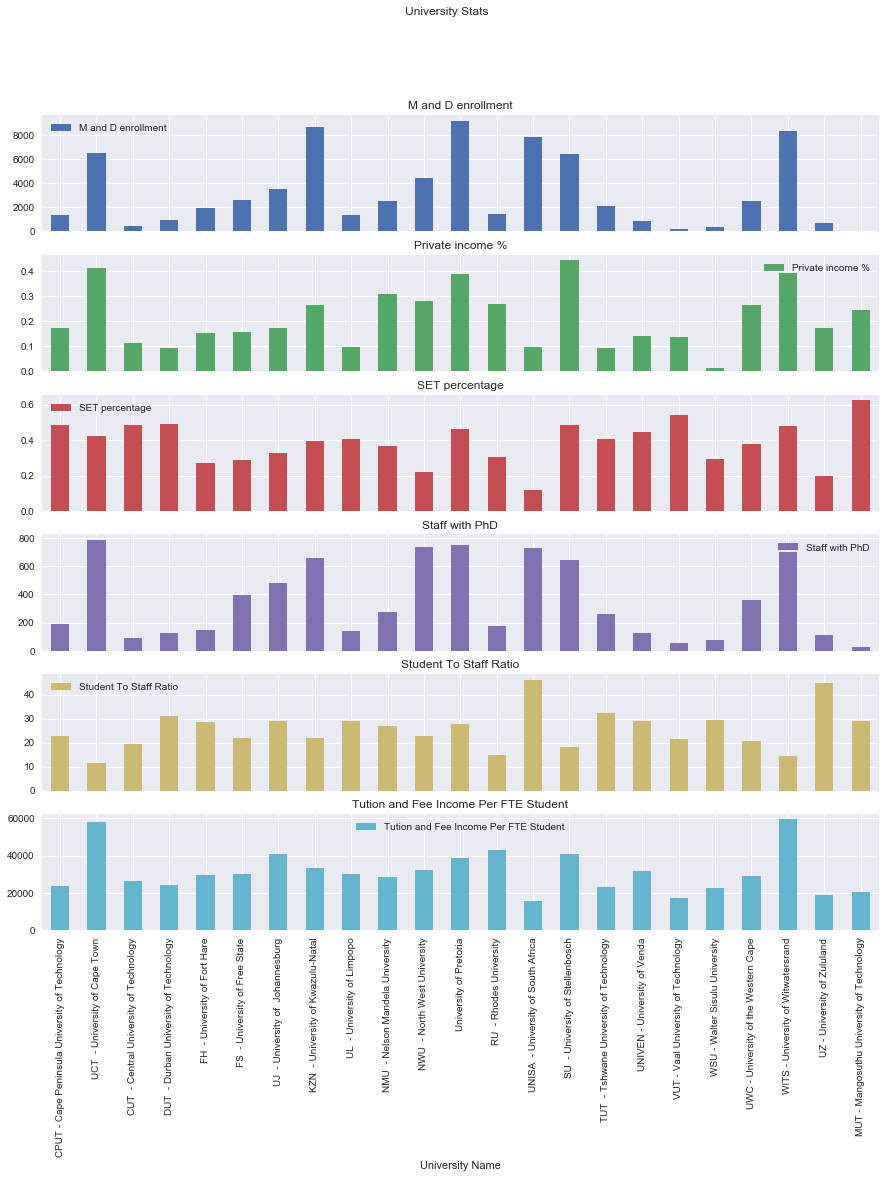

In [41]:
columns_to_exclude = ['University Name']
plotting_data = overall_data.loc[:,overall_data.columns.difference(columns_to_exclude)]
plotting_data.index = overall_data['University Name']
plotting_data.plot(subplots=True, use_index=True, sharex=True, kind='bar', figsize=(15, 15),
                  title='University Stats')

And now let's calculate the Pearson's correlation coefficient for each pair of variables. This is a measure of how much the variables vary together - 1 means they grow in set, -1 means as one grows the other declines, numbers inbetween show a weaker correlation. Wikipedia has a discussion on how to [interpret](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient#Interpretation) these numbers.

In [42]:
normalized_plotting_data = (plotting_data - plotting_data.mean()) / (plotting_data.max() - plotting_data.min())

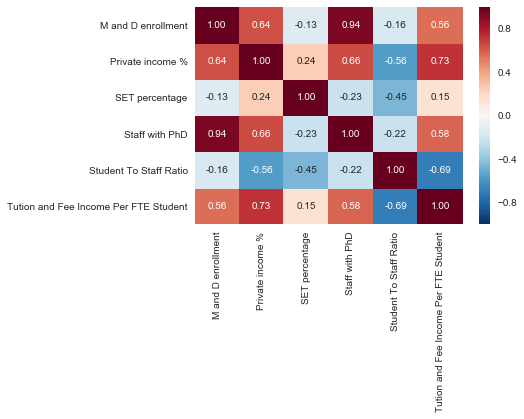

In [43]:
sns.heatmap(plotting_data.corr(), annot=True, fmt=".2f")


In [44]:
plotting_data_std = StandardScaler().fit_transform(plotting_data)
sklearn_pca = sklearnPCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(plotting_data_std)

In [45]:
pca_data = pandas.DataFrame(Y_sklearn, index=overall_data.index, columns=('PCA1', 'PCA2'))

/home/pvh/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


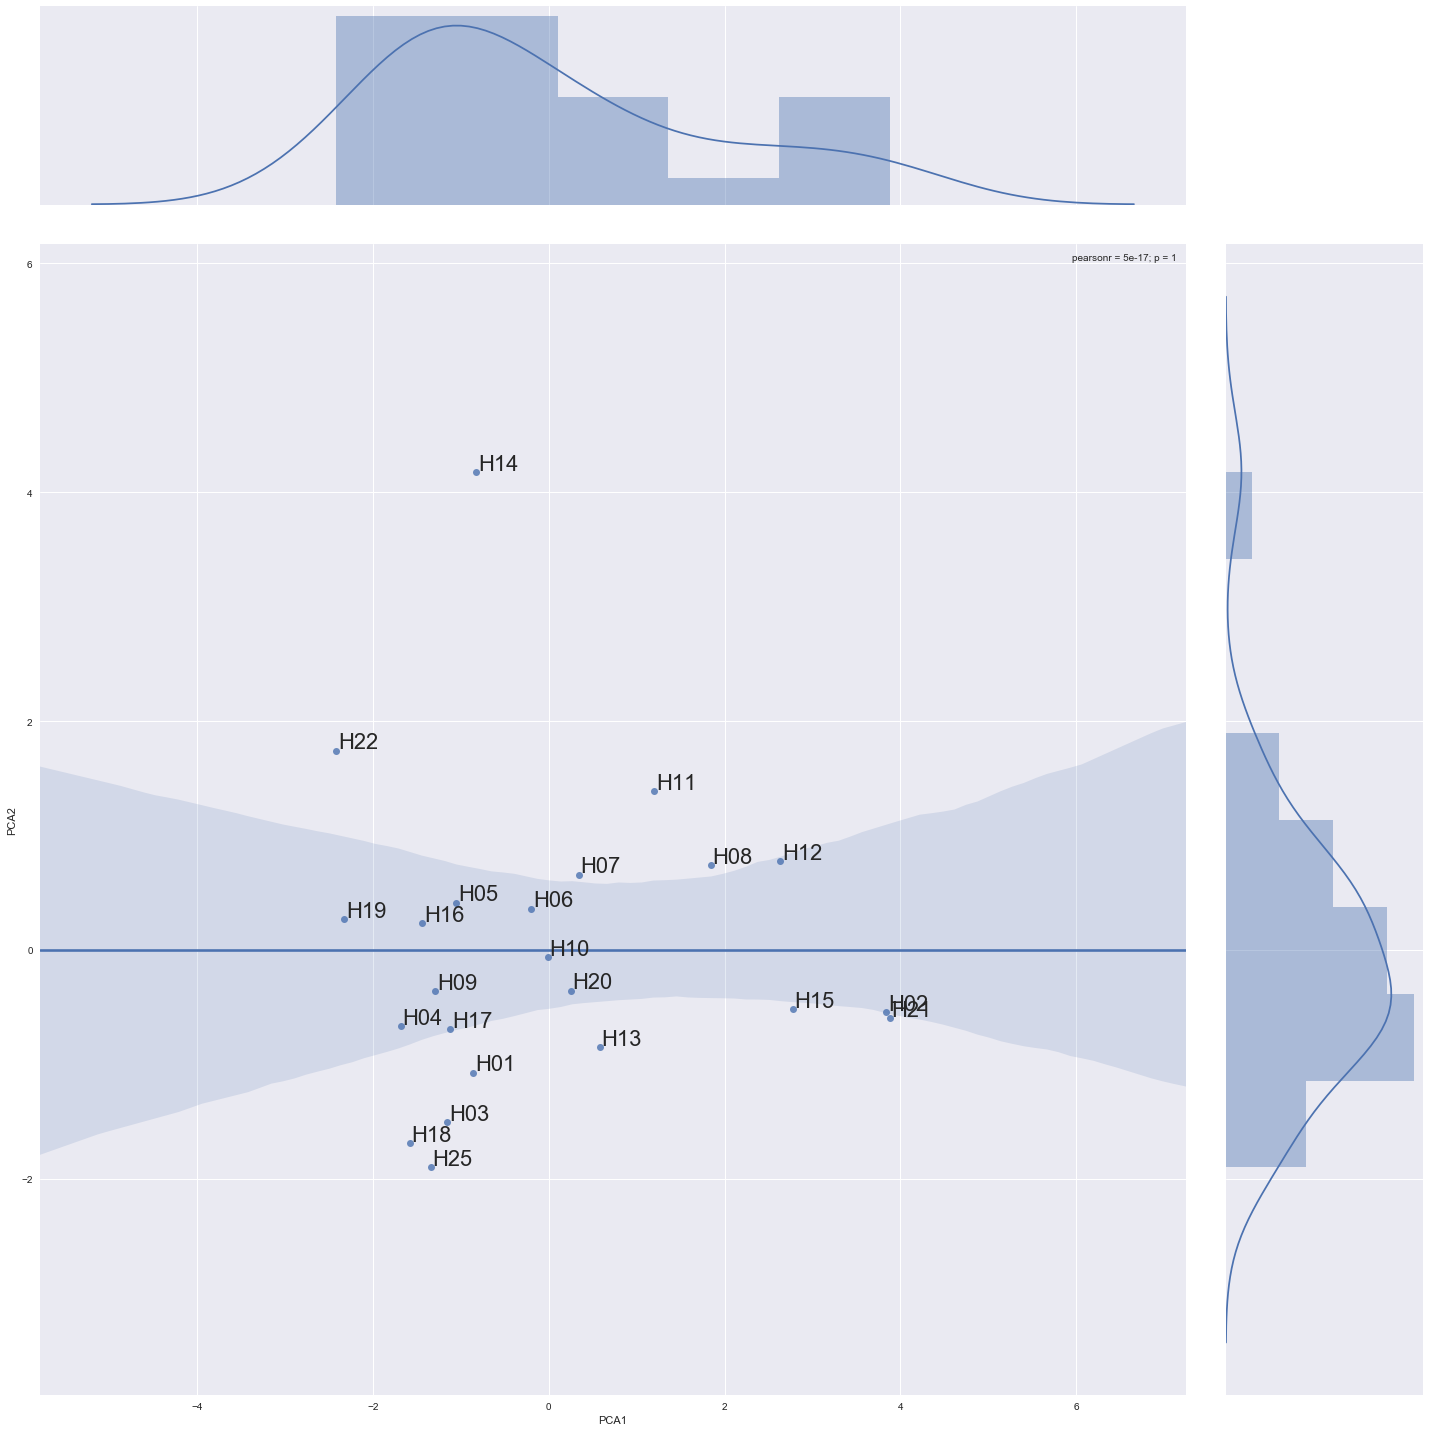

In [46]:
pca_plot = sns.jointplot(pca_data.loc[:,'PCA1'], pca_data.loc[:,'PCA2'], kind='reg', size=20)
def ann(row):
    ind = row[0]
    r = row[1]
    plt.gca().annotate(ind, xy=(r["PCA1"], r["PCA2"]), 
            xytext=(2,2), size=22, textcoords ="offset points", )
    
for row in pca_data.iterrows():
    ann(row)

plt.show()
    

In [47]:
overall_data.loc[:,'University Name']

H01    CPUT - Cape Peninsula University of Technology
H02                    UCT  - University of Cape Town
H03           CUT  - Central University of Technology
H04            DUT  - Durban University of Technology
H05                     FH  - University of Fort Hare
H06                    FS  - University of Free State
H07                 UJ  - University of  Johannesburg
H08                KZN  - University of Kwazulu-Natal
H09                       UL  - University of Limpopo
H10                  NMU  - Nelson Mandela University
H11                      NWU  - North West University
H12                            University of Pretoria
H13                           RU  - Rhodes University
H14               UNISA  - University of South Africa
H15                  SU  - University of Stellenbosch
H16           TUT  - Tshwane University of Technology
H17                      UNIVEN - University of Venda
H18               VUT - Vaal University of Technology
H19                    WSU -

What do I conclude from the above?

1. Clusters are not obvious.
2. The meaning of the principal components is not clear.

More analysis needed. Let's look at an [elbow plot](https://bl.ocks.org/rpgove/0060ff3b656618e9136b) to see if there is an obvious number of clusters in the principal component analysis.

In [48]:
def elbow_plot(dataframe, k_values):
    distortions = []
    k_values = list(range(2,20))
    for k in k_values:
        model = KMeans(n_clusters=k).fit(dataframe)
        model.labels_
        distortion = sum(np.min(cdist(dataframe, 
                                      model.cluster_centers_, 'euclidean'), axis=1)) / dataframe.shape[0]
        distortions.append(distortion)
    plt.plot(k_values, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')

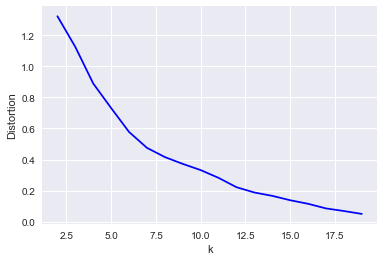

In [49]:
elbow_plot(pca_data, list(range(2,20)))

No obvious elbow there - although perhaps there is a little bit of one around $k=6$?

As an illustration of the value of PCA, let's do it again with the original dataset (with 6 (normalised) variables). There is even less of an "elbow".

My conclusion from all of this? The 6 input variables - Masters and PhD enrollment, private income %, SET enrollment percentage, number of staff with PhDs, staff to student ratio and tuition and fee income per FTE student - do not support the "3 cluster" model of South African higher education. 

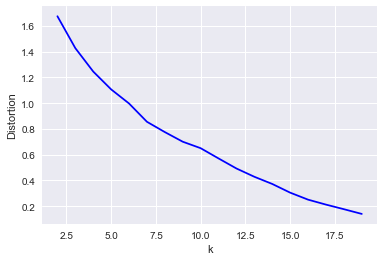

In [50]:
elbow_plot(plotting_data_std, list(range(2,20)))

Next step: add the output variables.

In [51]:
success_rate_spreadsheet = data_directory + '/Table 7 Success Rates.xlsx'

In [52]:
data = pandas.read_excel(success_rate_spreadsheet, skiprows=7, index_col=0)
data = data[1:-1]
data.index = data.index.str.strip()
data = data.drop(institutions_to_drop)

In [53]:
overall_data["Success Rate"] = data[2015]
overall_data

,SET percentage,University Name,M and D enrollment,Student To Staff Ratio,Staff with PhD,Private income %,Tution and Fee Income Per FTE Student,Success Rate
H01,0.487235,CPUT - Cape Peninsula University of Technology,1406,22.919523,187,0.171971,23767.346182,0.809855
H02,0.425516,UCT - University of Cape Town,6487,11.654388,787,0.409906,57697.008915,0.844420
H03,0.482521,CUT - Central University of Technology,416,19.407416,92,0.113739,26554.244786,0.771945
H04,0.489953,DUT - Durban University of Technology,968,31.248639,125,0.094298,24276.998251,0.835763
H05,0.272397,FH - University of Fort Hare,1921,28.431387,145,0.153493,29651.741131,0.803534
H06,0.289552,FS - University of Free State,2585,21.984036,396,0.157389,30169.856315,0.824616
H07,0.329122,UJ - University of Johannesburg,3549,28.818677,484,0.170576,40593.535201,0.837615
H08,0.397356,KZN - University of Kwazulu-Natal,8624,21.949128,655,0.265360,33617.256283,0.825203
H09,0.408971,UL - University of Limpopo,1376,28.874181,139,0.095110,30286.287967,0.859504
H10,0.366378,NMU - Nelson Mandela University,2498,26.735587,276,0.306460,28351.687151,0.805057


In [54]:
graduate_rate_spreadsheet = data_directory + '/graduation_data.csv'

The CHET data didn't include graduation rates, only number of graduates. The graduation rate is a crude statistic, it only measures how many graduations there are as a proportion of total students enrolled. As the [2015 DHET annual report](http://www.dhet.gov.za/DHET%20Statistics%20Publication/Statistics%20on%20Post-School%20Education%20and%20Training%20in%20South%20Africa%202015.pdf) notes, if the number of students enrolled is growing, it will push down the apparent graduation rate. So these are not great measures of throughput or dropout rate. More discussion on graduation rates is in the CHE's [Education Monitor #9](http://www.che.ac.za/sites/default/files/publications/Higher_Education_Monitor_9.pdf).

One of the problems with graduation rate is that it is calculated by comparing the number of graduates in the year to the same year's enrollment. If year on year enrollment increases it artificially deflates the graduation rate. And if year on year enrollment decreases it artificially inflates that rate. The CHET data *Table 2* shows that UNIVEN grew between 2011 and 2015, and WSU shrank.

Still, to reproduce the DHET calculation, the next section computes the crude graduation rate, differentiating between undergraduate and postgrad rates.

In [55]:
graduation_numbers_spreadsheet = data_directory + '/Table 8 Graduates by Qualification Type.xlsx'
enrollment_numbers_spreadsheet = data_directory + '/Table 3 Enrolment by Qualification Type.xlsx'

In [56]:
graduation_data = pandas.read_excel(graduation_numbers_spreadsheet, skiprows=194, index_col=0)
graduation_data = graduation_data[1:-1]
graduation_data.index = graduation_data.index.str.strip()
graduation_data = graduation_data.drop(institutions_to_drop)
graduation_data_columns_to_keep = ['Total undergraduate (UG)', 'Total postgraduate (PG)', 'Total']
graduation_data = graduation_data.loc[:, graduation_data_columns_to_keep]

In [57]:
enrollment_data = pandas.read_excel(enrollment_numbers_spreadsheet, skiprows=194, index_col=0)
enrollment_data =  enrollment_data[1:-1]
enrollment_data.index = enrollment_data.index.str.strip()
enrollment_data = enrollment_data.drop(institutions_to_drop)
enrollment_data_columns_to_keep = ['Total Undergraduate (UG)', 'Total Postgraduate (PG)', 'Total']
enrollment_data = enrollment_data.loc[:, enrollment_data_columns_to_keep]
enrollment_data.columns = graduation_data_columns_to_keep

In [58]:
crude_graduation_rate = graduation_data.div(enrollment_data)
postgraduate_percentage = enrollment_data['Total postgraduate (PG)'] / (
    enrollment_data['Total postgraduate (PG)'] + enrollment_data['Total undergraduate (UG)'])
crude_graduation_rate.columns = ['Undergraduate Graduation Rate %', 'Postgraduate Graduation Rate %',
                                'Total Graduation Rate %']
crude_graduation_rate['Percentage Postgraduate'] = postgraduate_percentage
overall_data['Percentage Postgraduate'] = postgraduate_percentage
crude_graduation_rate = pandas.concat([overall_data['University Name'], crude_graduation_rate], axis=1)
crude_graduation_rate

,University Name,Undergraduate Graduation Rate %,Postgraduate Graduation Rate %,Total Graduation Rate %,Percentage Postgraduate
Institution Number,,,,,
H01,CPUT - Cape Peninsula University of Technology,0.258445,0.220415,0.255310,0.054794
H02,UCT - University of Cape Town,0.220213,0.368643,0.260419,0.369711
H03,CUT - Central University of Technology,0.226703,0.420938,0.238709,0.064764
H04,DUT - Durban University of Technology,0.244905,0.172521,0.242312,0.035821
H05,FH - University of Fort Hare,0.188620,0.341969,0.225739,0.244140
H06,FS - University of Free State,0.186058,0.405799,0.225722,0.226179
H07,UJ - University of Johannesburg,0.227542,0.352901,0.245673,0.149155
H08,KZN - University of Kwazulu-Natal,0.190028,0.320942,0.220564,0.277909
H09,UL - University of Limpopo,0.206112,0.457072,0.238060,0.127553


I got distracted with another question - what is the proportion of postgrads to undergrads at the universities. I'll keep that column for later use. Anyway that's enough on almost-DHET-style postgrad, undergrad and total graduation rates.

The calculation above is crude, so I decided to chase another figure, one for which the data is easier to access: what is the percentage when you compare the number of students who were enrolled for a 3 year degree or diploma in 2013 graduated in 2015? I know many students in South Africa take more than 3 years to graduate. In fact many are enrolled in 4 year "extended curriculum" programmes. Still, for those who did enroll for a 3 year course, it is instructive to see how many graduates there were 3 years later. Not perfect, but instructive.

In [59]:
enrollment_data_2013 = pandas.read_excel(enrollment_numbers_spreadsheet, skiprows=132, index_col=0)
enrollment_data_2013 = enrollment_data_2013[1:27]
enrollment_data_2013.index = enrollment_data_2013.index.str.strip()
enrollment_data_2013 = enrollment_data_2013.drop(institutions_to_drop)
enrollment_data_2013_columns_to_keep = ['UG Dipl/Cert (3yrs)', '1st B Degree (3yrs)']
enrollment_data_2013.columns
enrollment_data_2013 = enrollment_data_2013.loc[:, enrollment_data_2013_columns_to_keep].fillna(0)
enrollment_data_2013["3 year UG enrollment"] = enrollment_data_2013.iloc[:,0] + enrollment_data_2013.iloc[:,1]

In [60]:
graduation_data_3yrUG = pandas.read_excel(graduation_numbers_spreadsheet, skiprows=194, index_col=0)
graduation_data_3yrUG = graduation_data_3yrUG[1:-1]
graduation_data_3yrUG.index = graduation_data_3yrUG.index.str.strip()
graduation_data_3yrUG = graduation_data_3yrUG.drop(institutions_to_drop)
graduation_data_3yrUG = graduation_data_3yrUG.loc[:, enrollment_data_2013_columns_to_keep].fillna(0)
graduation_data_3yrUG["3 year UG graduation"] = graduation_data_3yrUG.iloc[:,0] + graduation_data_3yrUG.iloc[:,1]

In [61]:
three_year_graduation_rate = pandas.concat([graduation_data_3yrUG['3 year UG graduation'].div(
    enrollment_data_2013['3 year UG enrollment']), overall_data['University Name']], axis=1)
three_year_graduation_rate.columns = ['3 year course graduation rate', 'University Name']
overall_data['3yr Graduation Rate'] = three_year_graduation_rate['3 year course graduation rate']
three_year_graduation_rate

,3 year course graduation rate,University Name
Institution Number,,
H01,0.198490,CPUT - Cape Peninsula University of Technology
H02,0.272181,UCT - University of Cape Town
H03,0.190476,CUT - Central University of Technology
H04,0.200301,DUT - Durban University of Technology
H05,0.189307,FH - University of Fort Hare
H06,0.176636,FS - University of Free State
H07,0.219889,UJ - University of Johannesburg
H08,0.180761,KZN - University of Kwazulu-Natal
H09,0.191313,UL - University of Limpopo


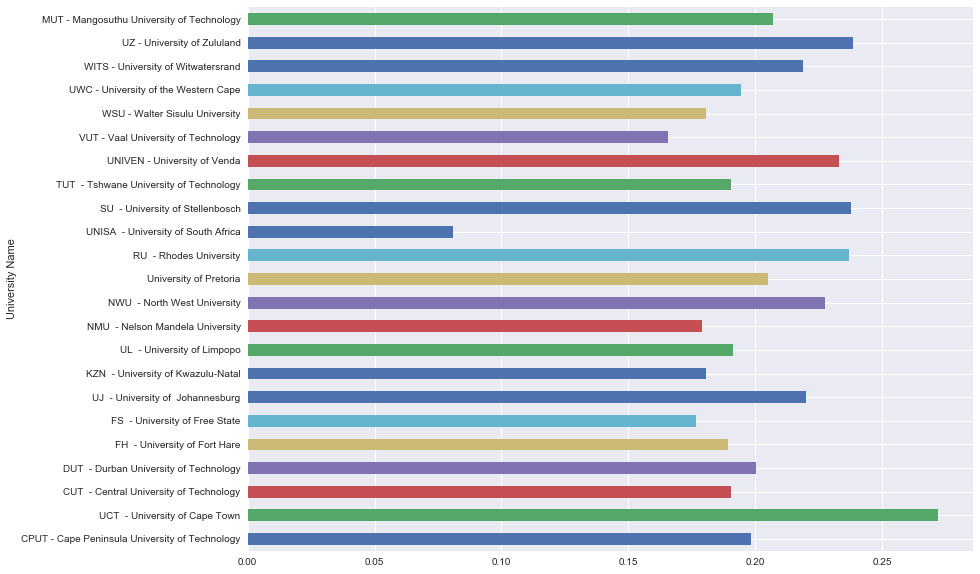

In [62]:
three_year_plottable_data = three_year_graduation_rate['3 year course graduation rate']
three_year_plottable_data.index = three_year_graduation_rate['University Name']
three_year_plottable_data.plot(kind='barh', figsize=(13,10))

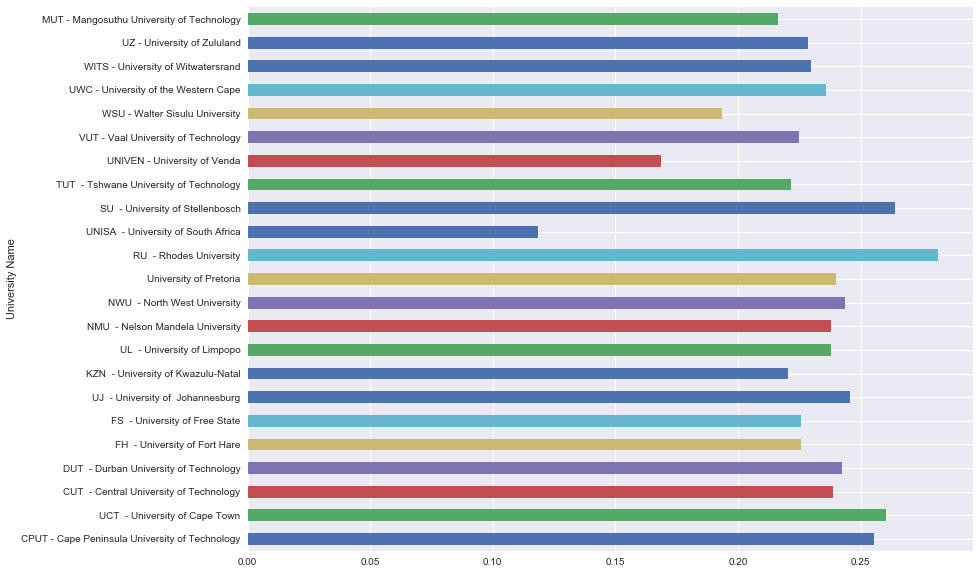

In [63]:
plottable_crude_graduation_rate = crude_graduation_rate['Total Graduation Rate %']
plottable_crude_graduation_rate.index = crude_graduation_rate['University Name']
plottable_crude_graduation_rate.plot(kind='barh', figsize=(13,10))

Working on this graduation data has been the least satisfying part of this data analysis, because it is so imprecise. Besides the limitations discussed above, one of the things to note is that distance programmes have a much higher non-completion rate than contact programmes. The DHET sets its undergraduate graduation rate target for 25% for contact programmes and 15% for distance programmes. Even with that in mind, UNISA's about 8% graduation rate is poor. And only a handful of institutions achieve the 25% target set by the DHET for contact programmes.

In [64]:
research_outputs_per_academic_spreadsheet = data_directory + '/Table 19 Weighted Total Research Output per Permanent Academic Staff.xlsx'

In [65]:
data = pandas.read_excel(research_outputs_per_academic_spreadsheet, skiprows=7, index_col=0)
data = data[1:-1]
data.index = data.index.str.strip()
data.drop('H26')
research_outputs_data = data[2015]
overall_data['WRO per Academic'] = research_outputs_data

Ok that is everything from the Cloete and Mbati presentation included (plus a little more). So let's look at some correlations:

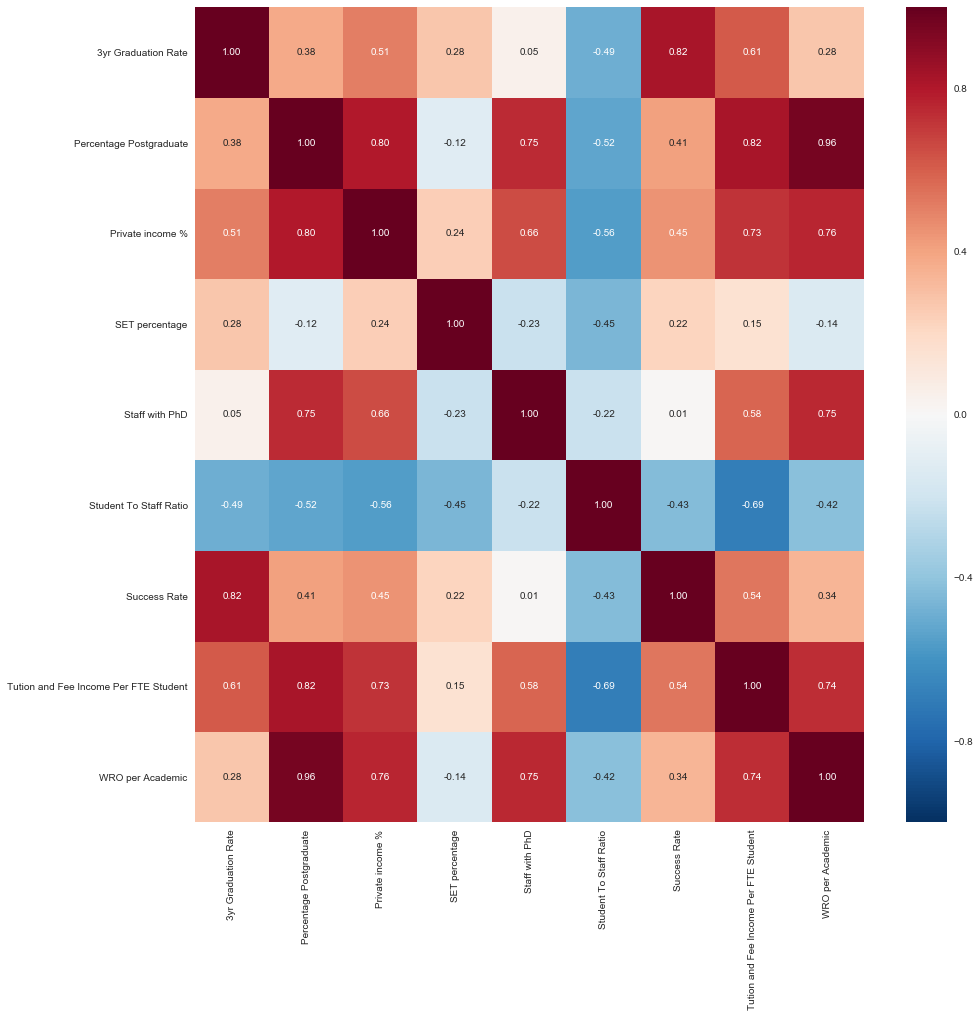

In [66]:
# let's drop M and D enrollment because we have a relative measure, Percentage Postgraduate
columns_to_exclude.append('M and D enrollment')
plotting_data = overall_data.loc[:,overall_data.columns.difference(columns_to_exclude)]
plt.figure(figsize=(15, 15))
sns.heatmap(plotting_data.corr(), annot=True, fmt=".2f")

What correlates? Let's look at this from 2 perspectives: firstly the "research university" perspective:

*Weighted Research Output per Academic staff member* strongly correlates with *Percentage Postgraduate*, *Private income %*, *Staff with PhD*, *Tuition Fee Income Per FTE Student*. There is a negative correlation with *Student to Staff Ratio* but it is at -0.42, so not as strong as the positive correlations. This is all evidence for the existence of a well funded "Postgrad and Research System". Interestingly, there is a weak corellation between research  output and *3yr Graduation Rate*, suggesting that undergraduate success is not necessary for research success. This might be evidence of divided universities, where the "Postgrad and Research System" does not entirely rely on the university's own undergraduate teaching mission. Postgrads and skilled staff can be (and are) recruited outside the system.

Secondly, the *undergraduate performance* perspective. Here the year on year *Success Rate* and the *3yr Graduation Rate* are the things to look at. The two measures correlate with each other - not surprisingly, since graduate requires year on year success. For both of these measures there are correlations with *Private income %* and *Tuition Fee Income Per FTE Student* - better resourced universities are more successful at graduating students - the correlation is not especially strong though. There is also an inverse correlation with *Student to Staff Ratio*, again not a terribly strong one though. I'd hazard a guess that there are missing factors, factors that can more strongly explain the undergraduate success story (or lack thereof).

Note that in the above data there is no information on race, class, gender, university location and a host of other socio-economic factors. I'll deal with those later. First a bit more PCA experimentation.

/home/pvh/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


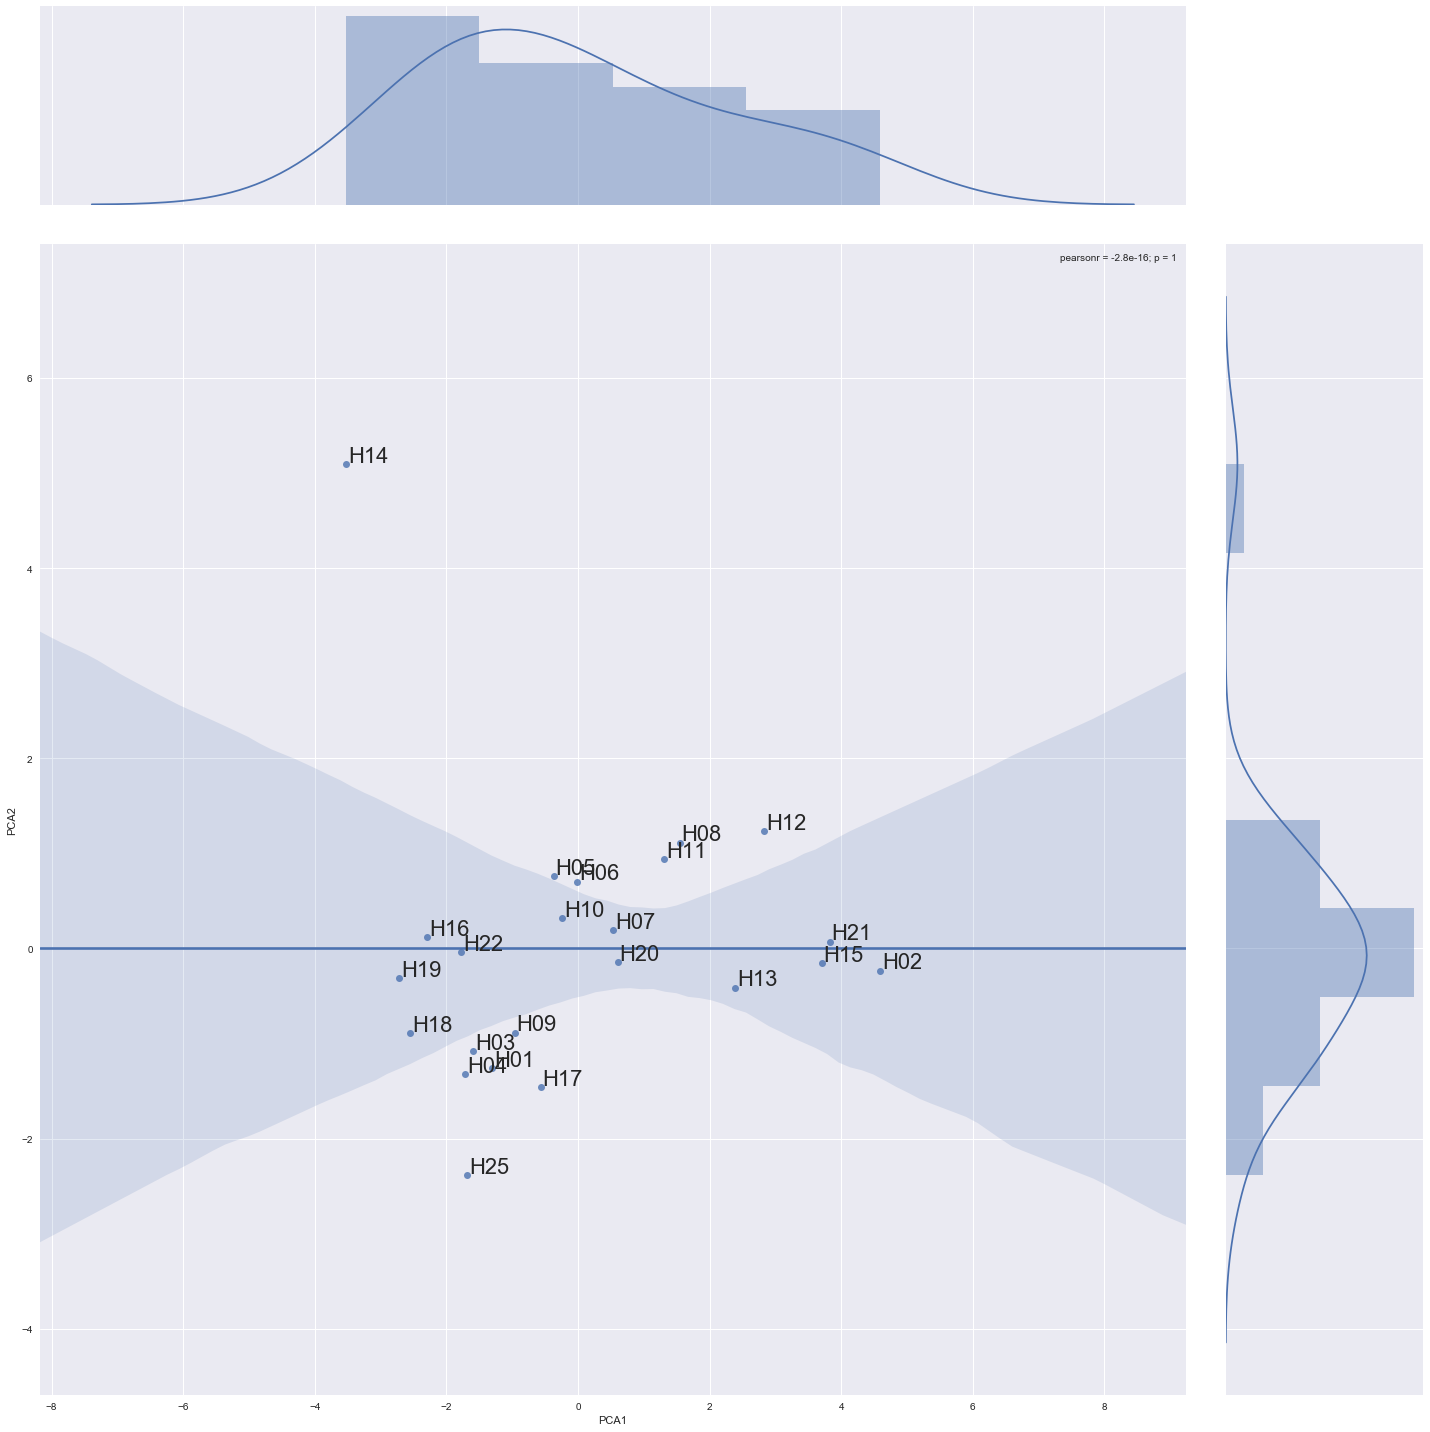

In [67]:
plotting_data_std = StandardScaler().fit_transform(plotting_data)
sklearn_pca = sklearnPCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(plotting_data_std)
pca_data = pandas.DataFrame(Y_sklearn, index=overall_data.index, columns=('PCA1', 'PCA2'))
pca_plot = sns.jointplot(pca_data.loc[:,'PCA1'], pca_data.loc[:,'PCA2'], kind='reg', size=20)
def ann(row):
    ind = row[0]
    r = row[1]
    plt.gca().annotate(ind, xy=(r["PCA1"], r["PCA2"]), 
            xytext=(2,2), size=22, textcoords ="offset points", )
    
for row in pca_data.iterrows():
    ann(row)

plt.show()


Do you see clusters? Maybe, a bit. I really should plot the centroids of a K-means analysis. But let's move on to an elbow plot for now: there seems to be a kink around 3 now. Leaving aside the fancy stuff, on to some graphs...

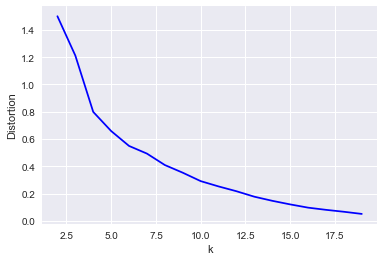

In [68]:
elbow_plot(pca_data, list(range(2,20)))

I've plotted each variable in the dataset. Some interesting patterns here:

1. The SET (Science, Engineering & Technology) subjects are - not surprisingly - most prominent in the Universities of Technology.
2. David Cooper's 3-class classification based on papers per academic per year still holds up. There are 5 universities with more than 2 papers per academic per year: UP, SU, UCKAR, UKZN, and Wits. FH is nipping on their heels, but watch out - according to [Mouton et al, 2017](http://www.sajs.co.za/extent-south-african-authored-articles-predatory-journals/johann-mouton-astrid-valentine) about a quarter of UFH's research output is being published in what might be pradatory journals. Quite worrying is that of the 10 institutions (MUT, WSU, VUT, CPUT, CUT, TUT, UZ, DUT, UNIVEN and UL) with 1 paper per academic per year or below, 8 also publish 10% of more of their research output in journals that might be predatory (only VUT and TUT miss out this "predatory list").
3. The top 5 "research intensive" universities mostly are also those with lowest student to staff ratios. UP is the exception here, as it is in the lower half of the list.
4. The top graphs are all strongly differentiated. They measure "objectively measurable" things like income, income source, staff to student ratio, staff with PhDs, proportion of students who are postgraduates. Something surprising happens with the last 2 graphs - the 3 year graduation rate, and the "success rate". Even if my calculations on the graduation rate are suspicious, the success rate is an officially recorded number: how many students progress at the end of their academic year. The fact that almost all universities record a 80% or better success rate (the national benchmark is apparently 80%) leaves me wondering what is going on. To be honest, it looks like these figures are being manipulated.

(While I've now added the racial enrollment percentages to these charts, I'm not discussing them here.)

In [69]:
enrollment_race_spreadsheet = data_directory + '/Table 5 Total Enrolments by Race.xlsx'

In [70]:
data = pandas.read_excel(enrollment_race_spreadsheet, skiprows=8, index_col=0, usecols="A,AN:AS")
data = data[1:-1].fillna(0)
data.index = data.index.str.strip()
data = data.drop(institutions_to_drop)
race_ratios = data.iloc[:,:-1].div(data['Total'], axis=0)
race_ratios.columns = [name + ' %' for name in race_ratios.columns]
old_overall_data = overall_data.copy()
overall_data = pandas.concat([overall_data, race_ratios], axis=1)

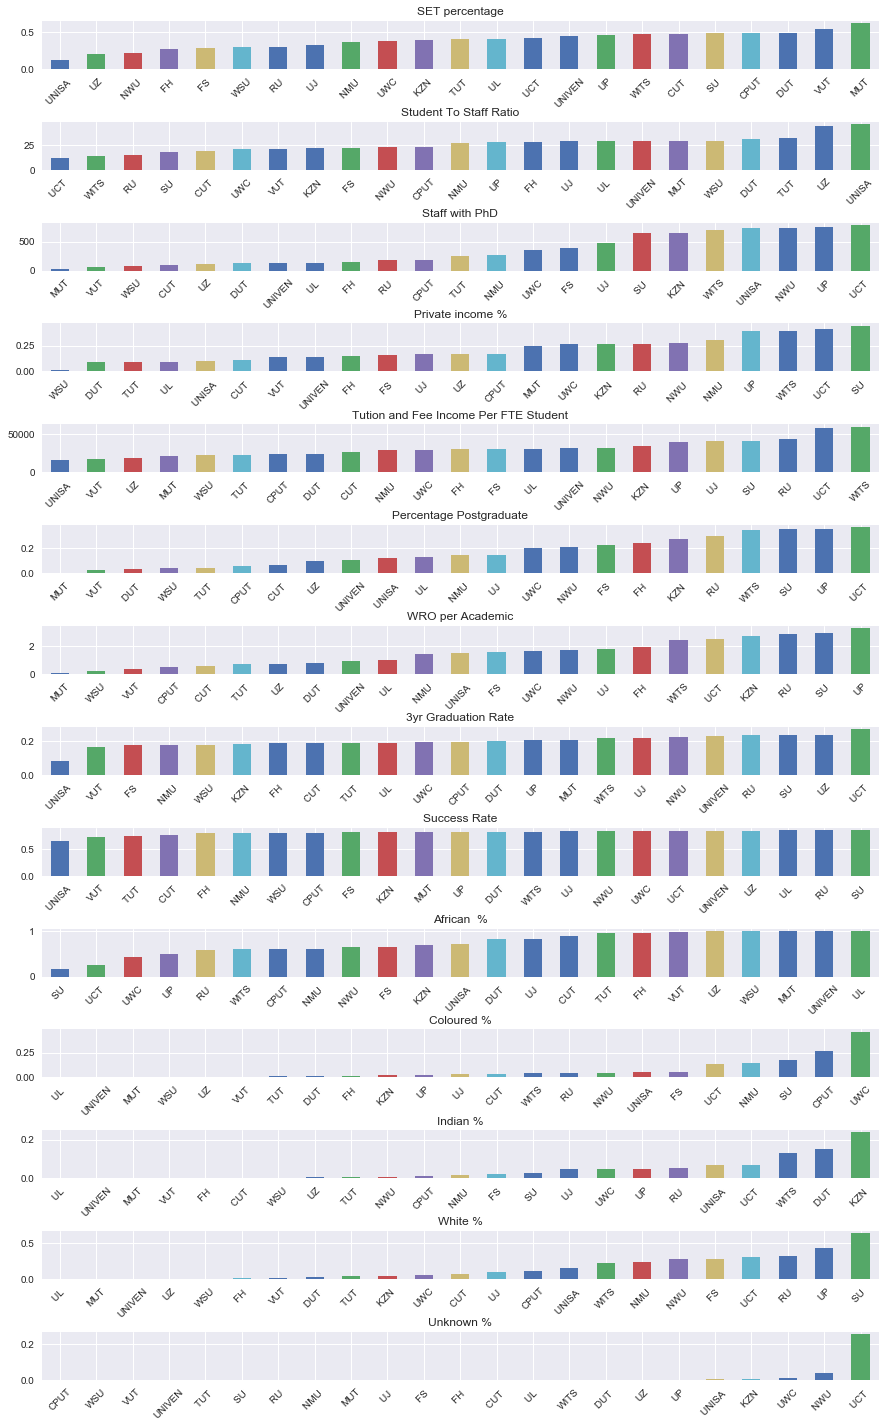

In [71]:
plt.figure(figsize=(15,15))

# columns_to_plot = list(overall_data.columns)
# del columns_to_plot[0]
# del columns_to_plot[1]
columns_to_plot = ['SET percentage',
       'Student To Staff Ratio', 'Staff with PhD', 'Private income %',
       'Tution and Fee Income Per FTE Student',
       'Percentage Postgraduate', 'WRO per Academic', '3yr Graduation Rate', 'Success Rate',
        'African  %', 'Coloured %', 'Indian %', 'White %', 'Unknown %']
f, axarr = plt.subplots(len(columns_to_plot), figsize=(15,25))
f.subplots_adjust(hspace=1.1)
for i, column_name in enumerate(columns_to_plot):
    temp_data = overall_data[column_name]
    temp_data.index = [(name.split(' - ')[0] if name != 'University of Pretoria' 
                        else 'UP') for name in list(overall_data['University Name'])]
    temp_data.sort_values().plot(rot=45, kind='bar', ax=axarr[i], title=column_name)
    axarr[i].set_xlabel('')
#     if i < len(columns_to_plot) - 1:
#         axarr[i].tick_params(
#             axis='x',          # changes apply to the x-axis
#             which='both',      # both major and minor ticks are affected
#             bottom='off',      # ticks along the bottom edge are off
#             top='off',         # ticks along the top edge are off
#             labelbottom='off') # labels along the bottom edge are off

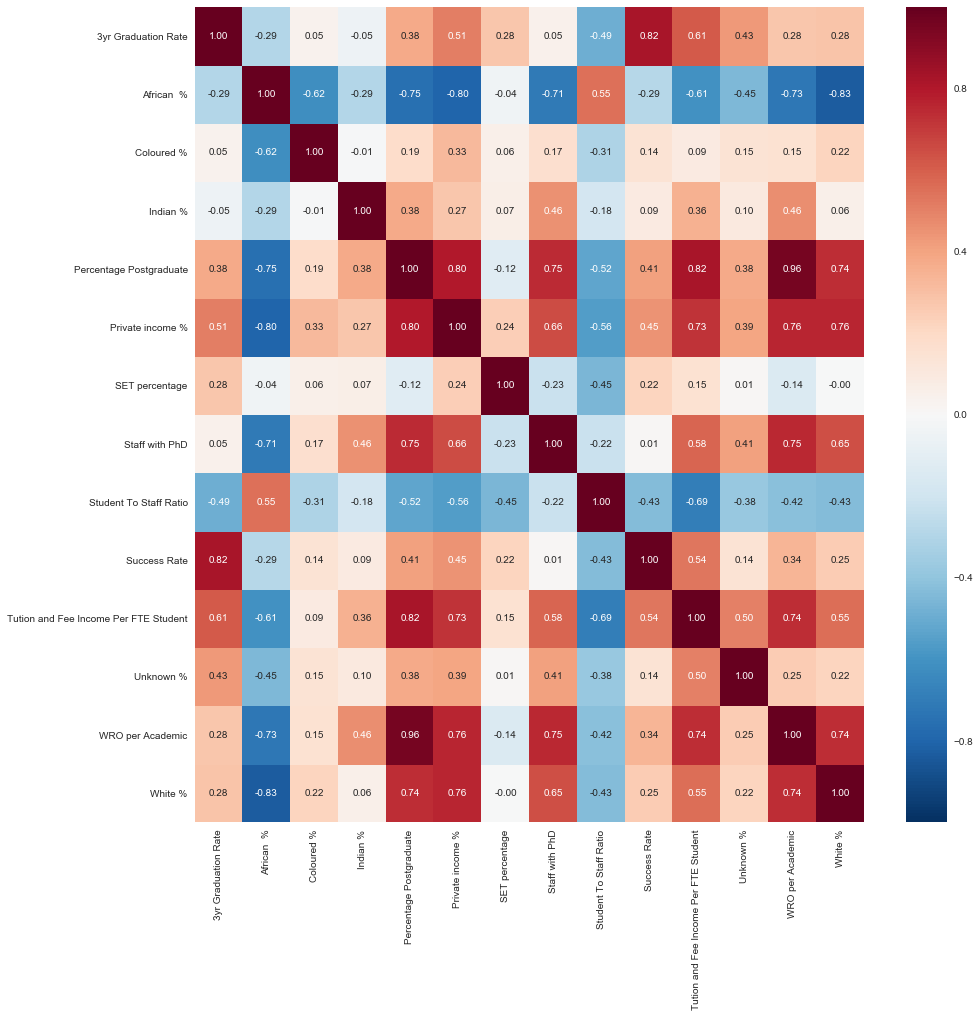

In [72]:
columns_to_exclude.append('M and D enrollment')
plotting_data = overall_data.loc[:,overall_data.columns.difference(columns_to_exclude)]
plt.figure(figsize=(15, 15))
sns.heatmap(plotting_data.corr(), annot=True, fmt=".2f")

Finally added ratios of students by race to the data. What can we see?

1. Of the 4 ratial groups (not counting Unknown), institutions with high percentage of African students have a weak negative correlation with poor undergraduate result markers (*3yr Graduation Rate* and *Success Rate*). Conversely institutons with a high % of white students correlate weakly with good undergraduate result markers. There's no significant correlation for the other 2 ratial groups.
2. A high % of African students at an institution correlates inversely with the presence of students from other racial groups. Mostly strongly when it comes to % of white students, most weakly when it comes to % of Indian students.
3. Higher % of white students correlates positively with what I previously called the "Postgraduate and Research System" markers. Conversely, higher % of African students correlates negatively with these markers.
4. Higher Student to Staff ratio correlates with higher % of African students.

All in all, this is a bleak picture.

In [73]:
data = pandas.read_csv(graduate_rate_spreadsheet, names=['University', 'Diploma', 'Degree'], usecols=[0,1,2])
unis_to_exclude = ('Sefako Makgatho Health Science University',  'Sol Plaatje University, Northern Cape', 
                   'University of Mpumalanga')
data = data[~data['University'].isin(unis_to_exclude)]
data = data[:-1]
data 

,University,Diploma,Degree
0,Cape Peninsula University of Technology,21,36
1,University of Cape Town,28,21
2,"Central University of Technology, Free State",20,27
3,Durban University of Technology,20,39
4,University of Fort Hare,44,18
5,University of the Free State,22,18
6,University of Johannesburg,20,23
7,University of KwaZulu-Natal,90,17
8,University of Limpopo,n.a.,21
9,Mangosuthu University of Technology,20,51


In [74]:
new_index_list = [] 
graduation_rate_list = []
uni_name_to_code = dict()
for i, row in enumerate(overall_data.loc[:,'University Name']):
    if ' - ' in row:
        uni_name = row.split(' - ')[1]
    else:
        uni_name = row
    code = overall_data.loc[:,'University Name'].index[i]
    uni_name_to_code[uni_name] = code
for i, row in data.iterrows():
    uni_name = row['University']
    if ',' in uni_name:
        uni_name = uni_name.split(',')[0]
    if uni_name == 'University of the Free State':
        uni_name = 'University of Free State'
    if uni_name == 'University of Johannesburg':
        uni_name = 'University of  Johannesburg'
    if uni_name == 'University of KwaZulu-Natal':
        uni_name = 'University of Kwazulu-Natal'
    if uni_name == 'Nelson Mandela Metropolitan University':
        uni_name = 'Nelson Mandela University'
    if uni_name == 'University of Western Cape':
        uni_name = 'University of the Western Cape'
    new_index_list.append(uni_name_to_code[uni_name])
    if 'Technology' in row['University']:
        graduation_rate = row['Diploma']
    else:
        graduation_rate = row['Degree']
    graduation_rate_list.append(graduation_rate)
data.index = pandas.Index(new_index_list)
new_data = pandas.DataFrame(data['University'], index=data.index)
new_data.columns = pandas.Index(['University Name'])
new_data['Graduation Rate %'] = graduation_rate_list
new_data

,University Name,Graduation Rate %
H01,Cape Peninsula University of Technology,21
H02,University of Cape Town,21
H03,"Central University of Technology, Free State",20
H04,Durban University of Technology,20
H05,University of Fort Hare,18
H06,University of the Free State,18
H07,University of Johannesburg,23
H08,University of KwaZulu-Natal,17
H09,University of Limpopo,21
H25,Mangosuthu University of Technology,20


In [75]:
data.index[data.loc[data['University'] == 'University of Venda'].index]

IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
len(new_index_list)

In [ ]:
overall_data['University Name']